# Light curves with the W22 Model looking at Four Redder Supernovae and Uniform Rv Prior

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from bayesn import SEDmodel

## Load the W22 Model

W22 model works with optical and NIR bands

In [2]:
model = SEDmodel(load_model='W22_model')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Current devices: [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]
Currently working in /root/partiiiproject
Loading built-in model W22_model


## Generate Fits

We generate the fits for our supernova data.
We are looking at four different supernova:\
CSPDR3_2005A.PKMJD.DAT\
CSPDR3_2006br.PKMJD.DAT\
sn2009I.Wstd_snana.dat\
sn2006X.Wstd_snana.dat

In [3]:
supernova_file = "/root/partiiiproject/CSPDR3_2005A.PKMJD.DAT"
supernova_name = "sn2005A"
mu_Rv_used = "uniform"
#sigma_R=0.5
#samples, sn_props = model.fit_from_file(supernova_file, mu_R=mu_Rv_used, sigma_R=sigma_R)
samples, sn_props = model.fit_from_file(supernova_file, RV='uniform', drop_bands=['u_CSP'])
#samples, sn_props = model.fit_from_file(supernova_file)

/root/miniforge3/envs/bayesn/lib/python3.11/site-packages/jax/_src/linear_util.py:193: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          AV[0]      2.10      0.06      2.10      2.00      2.19    274.19      1.01
          Ds[0]     34.25      0.06     34.25     34.16     34.34    252.93      1.01
          RV[0]      2.22      0.10      2.22      2.06      2.38    264.46      1.01
 eps_tform[0,0]      0.13      0.58      0.14     -0.84      1.06    760.47      1.00
 eps_tform[0,1]      1.14      0.53      1.14      0.32      2.04    673.49      1.00
 eps_tform[0,2]     -0.51      0.49     -0.51     -1.25      0.32   1000.79      1.00
 eps_tform[0,3]     -0.80      0.28     -0.80     -1.24     -0.36    637.57      1.00
 eps_tform[0,4]      2.74      0.27      2.75      2.30      3.20    841.76      1.00
 eps_tform[0,5]     -0.38      0.92     -0.41     -1.82      1.17   1021.51      1.00
 eps_tform[0,6]      0.70      0.94      0.71     -0.96      2.13   1139.58      1.00
 eps_tform[0,7]     -0.27      0.88     -0.31     -1.

## Load Observational Data

We read the observational data andits assosciated uncertainty 

In [4]:
meta, lcdata = sncosmo.read_snana_ascii(supernova_file, default_tablename='OBS')
lcdata = lcdata['OBS'].to_pandas()

## Use chains to get Fits to plot

Choose the bands we want to plot and the number of days on either side of the peak.

In [5]:
t = np.arange(-15, 25, 1) #Days on either side of the peak
bands = ['g_CSP', 'r_CSP', 'i_CSP', 'B_CSP', 'V_CSP', 'Y_RC', 'J_RC1', 'H_RC'] #Bands being used for plot
z, ebv_mw = sn_props
flux_grid = model.get_flux_from_chains(t, bands, samples, z, ebv_mw, mag=False, num_samples=10)

Getting best fit light curves from chains...


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.62s/it]


Turn the flux into an actual fit we can plot

In [6]:
fit, fit_err = flux_grid.mean(axis=(0, 1)), flux_grid.std(axis=(0, 1))

## Plot a graph

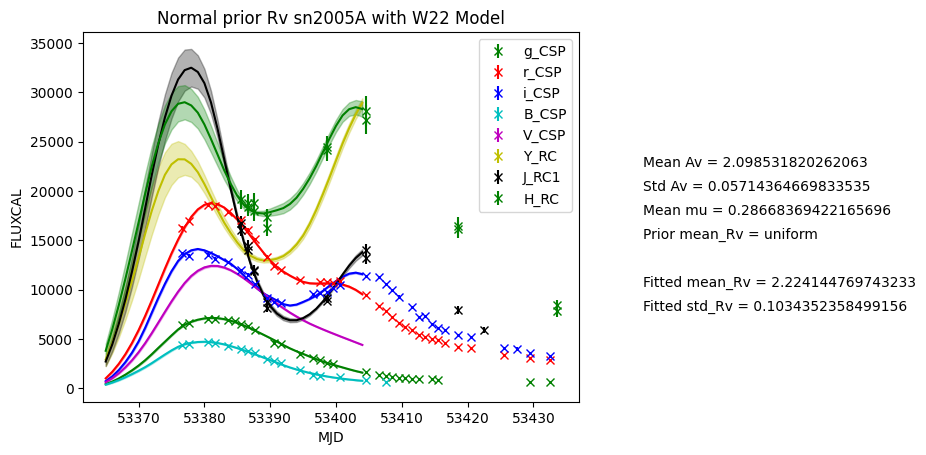

In [7]:
cs = ['g', 'r', 'b', 'c', 'm', 'y', 'k','g']
plot_t = t + meta['SEARCH_PEAKMJD']
for b_ind, b in enumerate(bands):
    b_data = lcdata[lcdata.FLT == b]
    plt.errorbar(b_data.MJD, b_data.FLUXCAL, b_data.FLUXCALERR, fmt=f'{cs[b_ind]}x', label=b)
    plt.plot(plot_t, fit[b_ind, :], color=cs[b_ind])
    plt.fill_between(plot_t, fit[b_ind, :] - fit_err[b_ind, :], fit[b_ind, :] + fit_err[b_ind, :], alpha=0.3, color=cs[b_ind])
plt.title('Normal prior Rv '+supernova_name+' with W22 Model')
plt.xlabel('MJD')
plt.ylabel('FLUXCAL')
plt.legend()
plt.figtext(1, .6, "Mean Av = " + str(np.mean(samples['AV'])))
plt.figtext(1, .55, "Std Av = " + str(np.std(samples['AV'])))
plt.figtext(1, .5, "Mean mu = " + str(np.mean(samples['theta'])))
plt.figtext(1, .45, "Prior mean_Rv = " + str(mu_Rv_used))
#plt.figtext(1, .4, "Prior std_Rv = " + str(sigma_R))
plt.figtext(1, .35, "Fitted mean_Rv = "+ str(np.mean(samples['RV'])))
plt.figtext(1, .3, "Fitted std_Rv = "+ str(np.std(samples['RV'])))
plt.savefig("/root/partiiiproject/RedderLightCurvesUniformW22Graphs/"+supernova_name+"NormalRv" + str(mu_Rv_used) +".png", bbox_inches='tight') #save plot
#plt.savefig("/root/partiiiproject/RedderLightCurvesUniformW22Graphs/"+supernova_name+"Fixed.png", bbox_inches='tight')
plt.show()

Plotted as Sub-Plots

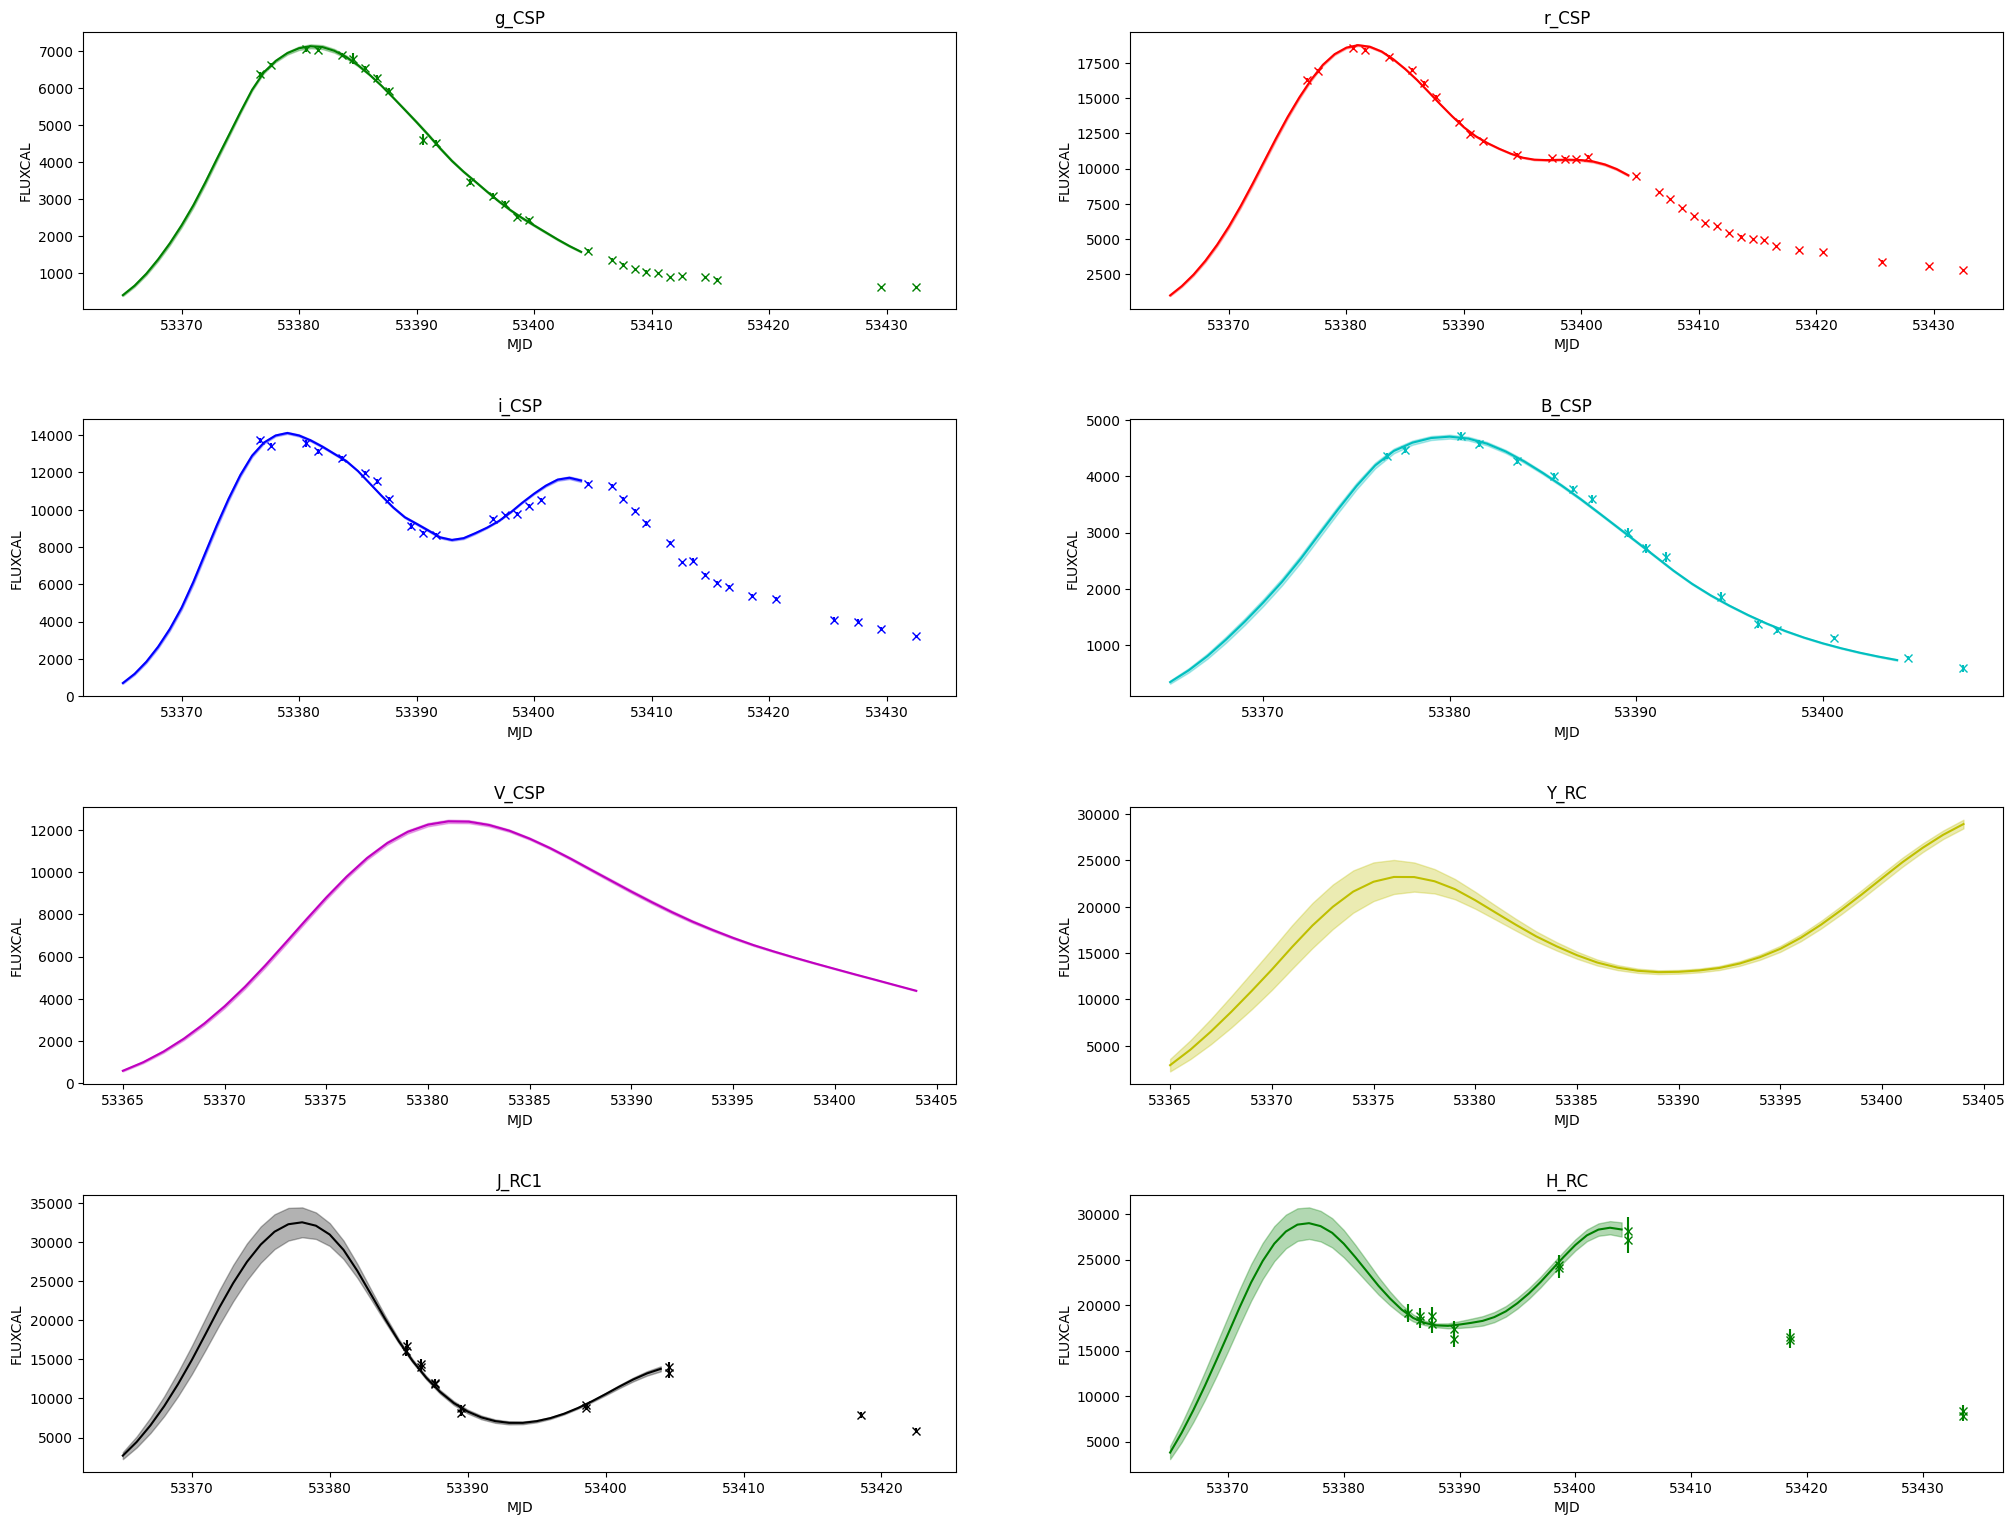

In [8]:
cs = ['g', 'r', 'b', 'c', 'm', 'y', 'k','g'] #colour scheme
plot_t = t + meta['SEARCH_PEAKMJD'] #Time is based around the peak for the supernova
figure, axis = plt.subplots(4, 2) #Sub plots 3 rows and 2 columns
for b_ind, b in enumerate(bands): #Loop through the bands given
    b_data = lcdata[lcdata.FLT == b] #get the original data for the band (previous method took first character!)
    axis[b_ind//2, b_ind%2].errorbar(b_data.MJD, b_data.FLUXCAL, b_data.FLUXCALERR, fmt=f'{cs[b_ind]}x', label=b)
    axis[b_ind//2, b_ind%2].plot(plot_t, fit[b_ind, :], color=cs[b_ind])
    axis[b_ind//2, b_ind%2].fill_between(plot_t, fit[b_ind, :] - fit_err[b_ind, :], fit[b_ind, :] + fit_err[b_ind, :], alpha=0.3, color=cs[b_ind])
    axis[b_ind//2, b_ind%2].set_title(b)
    axis[b_ind//2, b_ind%2].set_xlabel('MJD')
    axis[b_ind//2, b_ind%2].set_ylabel('FLUXCAL')
#axis.legend()
plt.subplots_adjust(left=0, right=3, bottom=0, top=3, wspace=0.2, hspace=0.4)
figure.show()

## Saving the plot to a file

Saving Sub Plot

In [9]:
figure.savefig("/root/partiiiproject/RedderLightCurvesUniformW22Graphs/"+supernova_name+"NormalRv" + str(mu_Rv_used)+ "Combined.png", bbox_inches='tight')

## A little look at Dust Values

(array([  3.,   9.,  45., 103., 211., 255., 225., 110.,  33.,   6.]),
 array([1.89090004, 1.92886098, 1.96682192, 2.00478285, 2.04274379,
        2.08070472, 2.11866566, 2.1566266 , 2.19458753, 2.23254847,
        2.27050941]),
 <BarContainer object of 10 artists>)

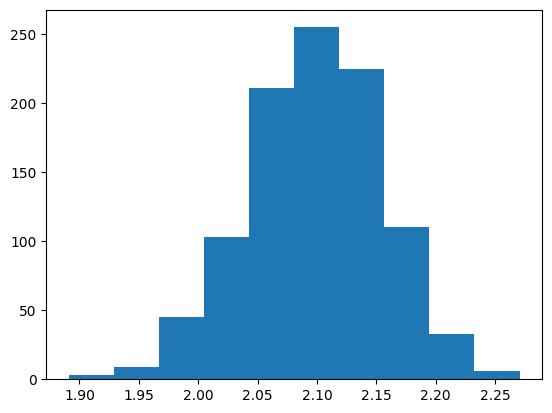

In [10]:
plt.hist(samples['AV'].flatten())

In [11]:
np.mean(samples['AV'])

Array(2.09853182, dtype=float64)

In [12]:
np.std(samples['AV'])

Array(0.05714365, dtype=float64)

In [13]:
np.mean(samples['theta'])

Array(0.28668369, dtype=float64)